# Automatic_GIF_Captioning

## Background
...

## Install Environment in GPU Farm


In [1]:
# Uncomment to install again
# !pip install --no-input  gensim  Ipython  nltk  pillow nltk tqdm matplotlib torchtext
# !pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html

## Requirements

In [2]:
# import the libraries.
import os
import pdb
import random
import shutil
from collections import Counter, defaultdict

import nltk
from gensim.models import Word2Vec
from IPython import display

nltk.download('punkt')  # it will takes some time
import json
import logging
import os
import random
import sys
import warnings
from pathlib import PurePosixPath
from typing import Union

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from nltk import word_tokenize
from nltk.translate.bleu_score import sentence_bleu
from PIL import Image, UnidentifiedImageError
from torchtext.data.metrics import bleu_score
from torch import nn
from torch.autograd import Variable
from torchvision import models, transforms
from tqdm import tqdm

[nltk_data] Downloading package punkt to
[nltk_data]     /userhome/cs/u3595931/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Here we will also define a constant to decide whether to use the GPU (with CUDA specifically) or the CPU. If you don't have a GPU, set this to False. Later when we create tensors, this variable will be used to decide whether we keep them on CPU or move them to GPU.

In [3]:
# check whether GPU is available, if not we use CPU instead
if torch.cuda.is_available():
    device='cuda'
else:
    device = 'cpu'
print('device: {}'.format(device))

device: cuda


## Downloading Data

In [4]:
all_data = json.load(open('data/pre-training.json'))

# Uncomment to download all data
#!rm -rf data/gif
#!mkdir data/gif
#for item in all_data:
#    !wget -c {item["url"]} -O {"data/gif/" + item["id"] + ".gif"} --timeout=2 -t 1

## Setting Parameters

In [5]:
# TRAIN_SAMPLE_NUM + VAL_SAMPLE_NUM + TEST_SAMPLE_NUM < NUM_OF_SAMPLES_DOWNLOADED to ensure no duplicate
TRAIN_SAMPLE_NUM = 4000
VAL_SAMPLE_NUM = 200
TEST_SAMPLE_NUM = 20

N_FRAMES = 10

## Setting up logging

In [6]:
# https://towardsdatascience.com/building-and-exporting-python-logs-in-jupyter-notebooks-87b6d7a86c4
logger = logging.getLogger()
formatter = logging.Formatter('%(levelname)s %(asctime)s: %(message)s')
logger.setLevel(logging.INFO)

consoleHandler = logging.StreamHandler(sys.stdout)

consoleHandler.setFormatter(formatter)
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)

## Converting GIFs into PNGs

In [7]:
def gif_to_png(filename: Union[str, bytes, os.PathLike]) -> None:
    """Converts a given gif file to a series of png files.
    Args:
        filename (Union[str, bytes, os.PathLike]): the path to the gif file.
    """

    # Handle the filename in the cases of bytes, str, and PathLike
    # Code from https://jod.al/2019/12/10/pathlib-and-paths-with-arbitrary-bytes/
    if isinstance(filename, bytes):
        filename = str(PurePosixPath(os.fsdecode(filename)))
    elif isinstance(filename, os.PathLike):
        filename = str(PurePosixPath(filename))
    logging.debug(f"Converted filename: {filename}")

    # Open the gif file
    try:
        gif = Image.open(filename)

        # Get the number of frames in the gif
        number_of_frames = 0
        number_of_frames = getattr(gif, 'n_frames')

        if number_of_frames == 0:
            warnings.warn(f"{gif} contains no frames!")
            return

        # Iterate over the frames and save them as pngs
        for current_frame in range(number_of_frames):
            gif.seek(current_frame)
            # Save frame according to the following format: 'data/gif/<filename_without_.gif>/<current_frame>.png'
            output_filename = f'data/png/{filename.split("/")[-1][:-4]}/{current_frame}.png'
            os.makedirs(os.path.dirname(output_filename), exist_ok=True)
            gif.save(output_filename)
        
        # save black images if number_of_frames is less than N_FRAMES
        for i in range(number_of_frames, N_FRAMES):
            output_filename = f'data/png/{filename.split("/")[-1][:-4]}/{i}.png'
            os.makedirs(os.path.dirname(output_filename), exist_ok=True)
            shutil.copyfile('data/black.png', output_filename)

        logging.info(f"{filename} converted to pngs!")
        
    except BaseException as e:
        logging.info(f"{e}: {filename}")

In [8]:
# Uncomment to convert all gifs to pngs
#for filename in os.listdir("data/gif"):
     #gif_to_png("data/gif/"+filename)

# Use this linux command to check for any folder in png have images less than 30
#find . -maxdepth 1 -type d -exec bash -c "echo -ne '{} '; ls '{}' | wc -l" \; |  awk '$NF<30'

## Preprocessing data

In [8]:
# def debug(id, all_data):
#     try: 
#         list(filter(lambda data: data["id"]==id, all_data))[0]["sentences"]
#     except:
#         print(id)

# format the three sets for convenient usage
all_ids = [filename for filename in os.listdir("data/png") if filename.isdigit()]
random.shuffle(all_ids)

train_ids = all_ids[:TRAIN_SAMPLE_NUM]
train_id_to_file = {train_id : "data/png/"+train_id+"/" for train_id in train_ids}
train_id_to_captions = {train_id : list(filter(lambda data: data["id"]==train_id, all_data))[0]["sentences"] for train_id in train_ids}

val_ids = all_ids[TRAIN_SAMPLE_NUM : TRAIN_SAMPLE_NUM+VAL_SAMPLE_NUM]
val_id_to_file = {val_id : "data/png/"+val_id+"/" for val_id in val_ids}
val_id_to_captions = {val_id : list(filter(lambda data: data["id"]==val_id, all_data))[0]["sentences"] for val_id in val_ids}

test_ids = all_ids[-TEST_SAMPLE_NUM:]
test_id_to_file = {test_id : "data/png/"+test_id+"/" for test_id in test_ids}
test_id_to_captions = {test_id : list(filter(lambda data: data["id"]==test_id, all_data))[0]["sentences"] for test_id in test_ids}

In [9]:
sentences = [sentence for caption_set in train_id_to_captions.values() for sentence in caption_set]

# Lower-case the sentence, tokenize them and add <SOS> and <EOS> tokens
sentences = [["<SOS>"] + word_tokenize(sentence.lower()) + ["<EOS>"] for sentence in sentences]

# Create the vocabulary. Note that we add an <UNK> token to represent words not in our vocabulary.

word_counts = Counter([word for sentence in sentences for word in sentence])
# vocabularySize = min(4000, len(word_counts)+1)
vocabularySize = len(word_counts)+1
vocabulary = ["<UNK>"] + [e[0] for e in word_counts.most_common(vocabularySize-1)]
word2index = {word:index for index,word in enumerate(vocabulary)}
one_hot_embeddings = np.eye(vocabularySize)

# Define the max sequence length to be the longest sentence in the training data. 
maxSequenceLength = max([len(sentence) for sentence in sentences])

def preprocess_numberize(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into list of numbers (denoting the index into the vocabulary).
    """
    tokenized = word_tokenize(sentence.lower())
        
    # Add the <SOS>/<EOS> tokens and numberize (all unknown words are represented as <UNK>).
    tokenized = ["<SOS>"] + tokenized + ["<EOS>"]
    numberized = [word2index.get(word, 0) for word in tokenized]
    
    return numberized

def preprocess_one_hot(sentence):
    """
    Given a sentence, in the form of a string, this function will preprocess it
    into a numpy array of one-hot vectors.
    """
    numberized = preprocess_numberize(sentence)
    
    # Represent each word as it's one-hot embedding
    one_hot_embedded = one_hot_embeddings[numberized]
    
    return one_hot_embedded

In [10]:
# Define a global transformer to appropriately scale images and subsequently convert them to a Tensor.
img_size = 224
loader = transforms.Compose([
  transforms.Resize(img_size),
  transforms.CenterCrop(img_size),
  transforms.ToTensor(),
]) 
def load_image(filename, volatile=False):
    """
    Simple function to load and preprocess the image.

    1. Open the image.
    2. Scale/crop it and convert it to a float tensor.
    3. Convert it to a variable (all inputs to PyTorch models must be variables).
    4. Add another dimension to the start of the Tensor (b/c VGG expects a batch).
    5. Move the variable onto the GPU.
    """
    image = Image.open(filename).convert('RGB')
    image_tensor = loader(image).float()
    image_var = Variable(image_tensor, volatile=volatile).unsqueeze(0)
    return image_var

## Exploring Data
We can explore the data a bit, to get a sense of what we're working with.

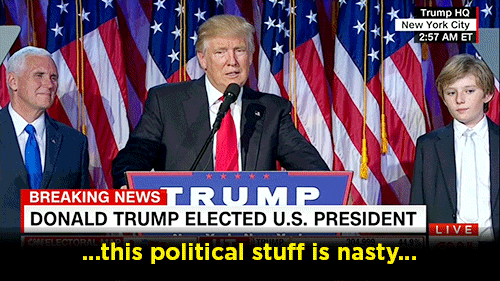

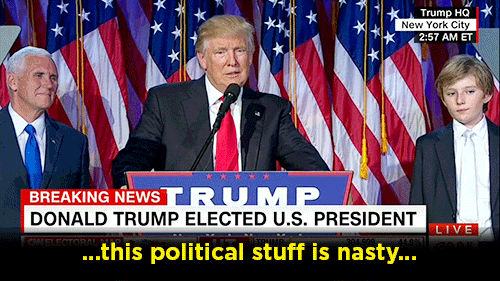

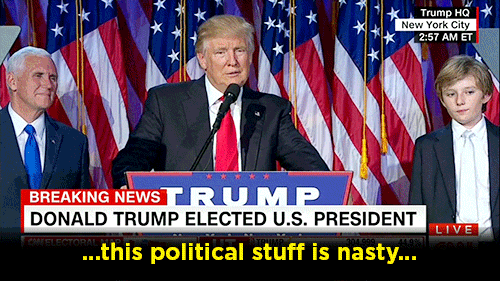

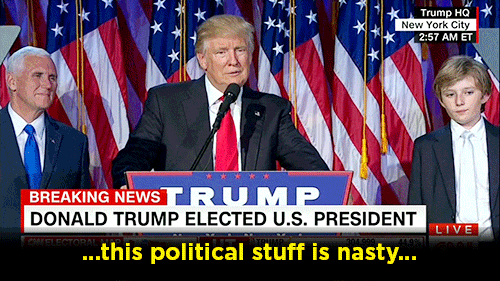

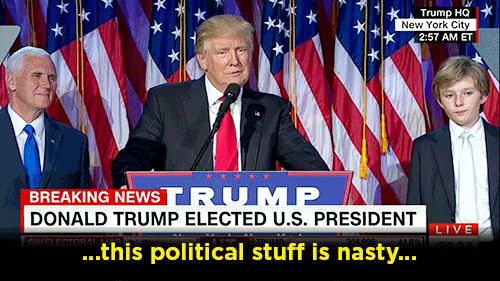

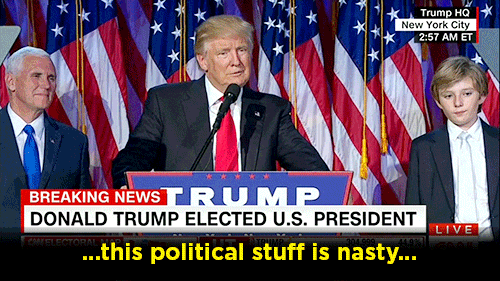

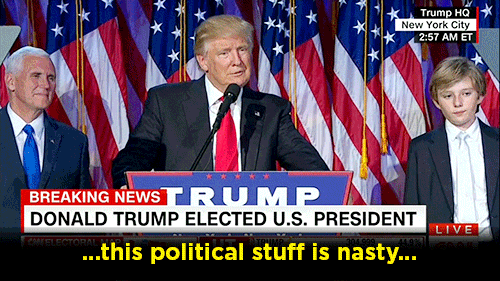

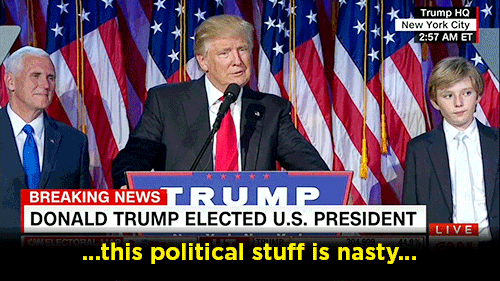

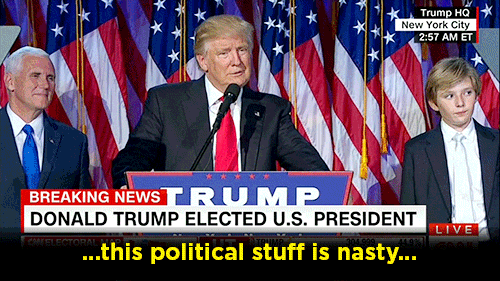

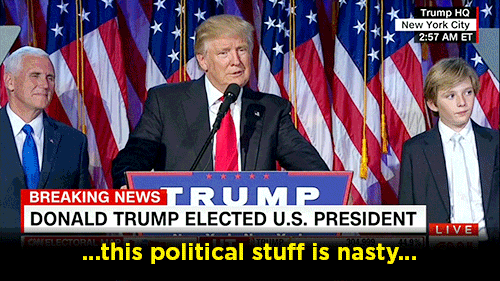

person elected president of the states


In [14]:
explore_id = random.choice(train_ids)

for i in range(N_FRAMES):
    display.display(Image.open(f"{train_id_to_file[explore_id]}{i}.png"))

for caption in train_id_to_captions[explore_id]:
    print(caption)

## Image Encoder
We load in a pre-trained VGG-16 model and remove the final layer.

In [12]:
vgg_model = models.vgg16(pretrained=True).to(device)
vgg_model.eval()

# Remove the final layer of the classifier, and indicate to PyTorch that the model is being used for inference
# rather than training (most importantly, this disables dropout).
modified_classifier = nn.Sequential(*list(vgg_model.classifier.children())[:-1])
modified_classifier.eval()

# Reassign the modified classifier back to the VGG model
vgg_model.classifier = modified_classifier

# Print out the model to see what it looks like now
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Process Data
We now convert each image, into a vector representation, that serves as a semantic descriptor of the image. We do this by passing it through our modified VGG-16 model.

In [13]:
training_vectors = []
    
for i,image_id in enumerate(tqdm(train_ids)):
    gif_vector = []
    for frame in range(N_FRAMES):
        # Load/preprocess the image.
        img = load_image(f"{train_id_to_file[image_id]}{frame}.png").to(device)

        # Run through the convolutional layers and resize the output.
        output = vgg_model(img)
        gif_vector.append(np.array(list(output.squeeze().detach().cpu().numpy())))

    training_vectors.append(gif_vector)

# For simplicity, we convert this to a numpy array and save the result to a file.
training_vectors = np.stack(training_vectors, axis=0)
if not os.path.exists('outputs'):
    os.makedirs('outputs')
np.save(open('outputs/training_vectors', 'wb+'), training_vectors)

  0%|          | 0/4000 [00:00<?, ?it/s]/userhome/cs/u3595931/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 4000/4000 [10:04<00:00,  6.62it/s] 


In [15]:
# Next we vectorize all of the validation images and write the results to a file.
validation_vectors = []

for image_id in tqdm(val_ids):
    gif_vector = []
    for frame in range(N_FRAMES):
        # Load/preprocess the image.
        img = load_image((f"{val_id_to_file[image_id]}{frame}.png")).to(device)

        # Run through the convolutional layers and resize the output.
        features_output = vgg_model.features(img)
        classifier_input = features_output.view(1, -1)

        # Run through all but final classifier layers.
        output = modified_classifier(classifier_input)
        gif_vector.append(np.array(list(output.squeeze().detach().cpu().numpy())))
    validation_vectors.append(gif_vector)

# For simplicity, we convert this to a numpy array and save the result to a file.
validation_vectors = np.array(validation_vectors)
np.save(open('outputs/validation_vectors', 'wb+'), validation_vectors)


# Next we vectorize all of the test images and write the results to a file.
test_vectors = []

for image_id in tqdm(test_ids):
    gif_vector = []
    for frame in range(N_FRAMES):
        # Load/preprocess the image.
        img = load_image((f"{test_id_to_file[image_id]}{frame}.png")).to(device)

        # Run through the convolutional layers and resize the output.
        features_output = vgg_model.features(img)
        classifier_input = features_output.view(1, -1)

        # Run through all but final classifier layers.
        output = modified_classifier(classifier_input)
        gif_vector.append(np.array(list(output.squeeze().detach().cpu().numpy())))
    test_vectors.append(gif_vector)

# For simplicity, we convert this to a numpy array and save the result to a file.
test_vectors = np.array(test_vectors)
np.save(open('outputs/test_vectors', 'wb+'), test_vectors)

100%|██████████| 20/20 [00:03<00:00,  6.31it/s]


In [16]:
# Load in the vectors and print their sizes
training_vectors = np.load(open('outputs/training_vectors', 'rb'))
validation_vectors = np.load(open('outputs/validation_vectors', 'rb'))

print(training_vectors.shape)
print(validation_vectors.shape)

train_id_to_vector = {}
for i, train_id in enumerate(train_ids):
    train_id_to_vector[train_id] = training_vectors[i]

(4000, 10, 4096)
(200, 10, 4096)


### Captioning Model

In [17]:

class EncoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderGRU, self).__init__()
        self.gru= nn.GRU(input_size=input_size, hidden_size=hidden_size, batch_first=True)

    def forward(self, inputs):
        return self.gru(inputs)
    
class DecoderGRU(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DecoderGRU, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, input, hidden):
        
        
        output = F.relu(input)
        output, hidden = self.gru(output, hidden)
        output = self.out(output)
        output = F.log_softmax(output.squeeze(), dim=-1)
        return output.unsqueeze(0), hidden
    
encoder = EncoderGRU(input_size=4096, hidden_size=300).to(device)
decoder = DecoderGRU(input_size=len(vocabulary), hidden_size=300*N_FRAMES, output_size=len(vocabulary)).to(device)

print(encoder)
print(decoder)

EncoderGRU(
  (gru): GRU(4096, 300, batch_first=True)
)
DecoderGRU(
  (gru): GRU(6254, 3000)
  (out): Linear(in_features=3000, out_features=6254, bias=True)
)


## Training the Models
### Defining the Loss Function
The next two functions are part of some other deep learning frameworks, but PyTorch has not yet implemented them. We can find some commonly-used open source worked arounds after searching around a bit: https://gist.github.com/jihunchoi/f1434a77df9db1bb337417854b398df1.

In [18]:
# The next two functions are part of some other deep learning frameworks, but PyTorch
# has not yet implemented them. We can find some commonly-used open source worked arounds
# after searching around a bit: https://gist.github.com/jihunchoi/f1434a77df9db1bb337417854b398df1.
def _sequence_mask(sequence_length, max_len=None):
    if max_len is None:
        max_len = sequence_length.data.max()
    batch_size = sequence_length.size(0)
    seq_range = torch.arange(0, max_len).long()
    seq_range_expand = seq_range.unsqueeze(0).expand(batch_size, max_len)
    seq_range_expand = Variable(seq_range_expand)
    if sequence_length.is_cuda:
        seq_range_expand = seq_range_expand.cuda()
    seq_length_expand = (sequence_length.unsqueeze(1)
                         .expand_as(seq_range_expand))
    return seq_range_expand < seq_length_expand


def compute_loss(logits, target, length):
    """
    Args:
        logits: A Variable containing a FloatTensor of size
            (batch, max_len, num_classes) which contains the
            unnormalized probability for each class.
        target: A Variable containing a LongTensor of size
            (batch, max_len) which contains the index of the true
            class for each corresponding step.
        length: A Variable containing a LongTensor of size (batch,)
            which contains the length of each data in a batch.

    Returns:
        loss: An average loss value masked by the length.
    """
    # logits_flat: (batch * max_len, num_classes)
    logits_flat = logits.view(-1, logits.size(-1))
    # log_probs_flat: (batch * max_len, num_classes)
    log_probs_flat = logits_flat
    # target_flat: (batch * max_len, 1)
    target_flat = target.view(-1, 1)
    # losses_flat: (batch * max_len, 1)
    losses_flat = -torch.gather(log_probs_flat, dim=1, index=target_flat)
    # losses: (batch, max_len)
    losses = losses_flat.view(*target.size())
    # mask: (batch, max_len)
    mask = _sequence_mask(sequence_length=length, max_len=target.size(1))
    losses = losses * mask.float()
    loss = losses.sum() / length.float().sum()
    return loss

### Training Function
The function below trains the model. There's some interesting ideas in the function below, such as:

- Teacher forcing
- Masked loss
- Gradient Clipping

In [24]:
def train(input_variables,
          embed_caption, 
          target_caption,
          input_lens,
          encoder, 
          decoder, 
          encoder_optimizer, 
          decoder_optimizer, 
          criterion, 
          embeddings=one_hot_embeddings):
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    # Pass the image through the encoder
    encoder_output, _ = encoder(input_variables)
    encoder_output = encoder_output.reshape([10, N_FRAMES*300]).unsqueeze(0)
    
    # Construct the decoder input (initially <SOS> for every batch)
    decoder_input = Variable(torch.FloatTensor([[embeddings[word2index["<SOS>"]]
                                                for i in range(embed_caption.size(1))]])).to(device)

    # Set the initial hidden state of the decoder to be the output of the encoder
    decoder_hidden = (encoder_output)

    # Prepare the results tensor
    all_decoder_outputs = Variable(torch.zeros(*embed_caption.size())).to(device)
        
    all_decoder_outputs[0] = decoder_input
        
    # Iterate over the indices after the first.
    for t in range(1,embed_caption.size(0)):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    
        if random.random() <= 0.8:
            decoder_input = embed_caption[t].unsqueeze(0)
        else:
            topv, topi = decoder_output.data.topk(1)
                       
            #Prepare the inputs
            decoder_input = torch.stack([Variable(torch.FloatTensor(embeddings[ni])).to(device)
                                         for ni in topi.squeeze()]).unsqueeze(0)
        
        # Save the decoder output
        all_decoder_outputs[t] = decoder_output
        
    loss = compute_loss(all_decoder_outputs.transpose(0,1).contiguous(),
                        target_caption.transpose(0,1).contiguous(), 
                        Variable(torch.LongTensor(input_lens)).to(device))

    loss.backward()
    
    torch.nn.utils.clip_grad_norm(encoder.parameters(), 10.0)
    torch.nn.utils.clip_grad_norm(decoder.parameters(), 10.0)

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss

In [22]:
# Captioning an image
def caption_image(image_vector, embeddings=one_hot_embeddings, max_length=20):
    """
    Given an image vector, caption the image.
    """
    # Pass the image through the encoder
    input_variable = Variable(torch.FloatTensor([image_vector])).to(device)
    encoder_output, (hidden) = encoder(input_variable)
    encoder_output = encoder_output.reshape([1, N_FRAMES*300]).unsqueeze(0)
    
    # Construct the decoder input (initially <SOS> for every batch)
    decoder_input = Variable(torch.FloatTensor([[embeddings[word2index["<SOS>"]]]])).to(device)
    
    # Set the initial hidden state of the decoder to be the output of the encoder
    decoder_hidden = (encoder_output)
    
    # Iterate over the indices after the first.
    decoder_outputs = []
    for t in range(1,max_length):
        decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden)
    
        # Get the top result
        topv, topi = decoder_output.data.topk(1)
        ni = topi[0][0]
        decoder_outputs.append(ni)

        if vocabulary[ni] == "<EOS>":
            break
        
        #Prepare the inputs
        decoder_input = Variable(torch.FloatTensor([[embeddings[ni]]])).to(device)

    return ' '.join(vocabulary[i] for i in decoder_outputs)

In [25]:
def pad_seq(arr, length, pad_token):
    """
    Pad an array to a length with a token.
    """
    if len(arr) == length:
        return np.array(arr)
    
    return np.concatenate((arr, [pad_token]*(length - len(arr))))

loss_list = []
encoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01) 
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=0.01) 
criterion = nn.CrossEntropyLoss()  

# Formulate the training data
train_data = [(train_id,caption) for train_id,captions in train_id_to_captions.items() 
              for caption in captions if len(caption) > 0]
random.shuffle(train_data)

num_epochs = 10
batch_size = 10
for epoch_id in range(num_epochs):
    print('Epoch: {}'.format(epoch_id))
    for i in range(len(train_data)//batch_size):
        # Get the data in the batch
        batch = train_data[i*batch_size:(i+1)*batch_size]
        
        # Get all of the image vectors
        input_variable = np.stack([train_id_to_vector[train_id] for train_id,_ in batch])
        input_variable = Variable(torch.FloatTensor(input_variable)).to(device)
        
        
        # Get the sentences
        sentences = [sentence for _,sentence in batch]
        
        # Get the sentence lengths
        sentence_lens = [len(preprocess_numberize(sentence)) for sentence in sentences]
                
        # Determine length to pad everything to
        max_len = max(sentence_lens)
        
        # Preprocess all of the sentences in each batch
        one_hot_embedded_list = [preprocess_one_hot(sentence) for sentence in sentences]
        one_hot_embedded_list_padded = [pad_seq(embed, max_len, np.zeros(len(vocabulary))) 
                                        for embed in one_hot_embedded_list]

        numberized_list = [preprocess_numberize(sentence) for sentence in sentences]
        numberized_list_padded = [pad_seq(numb, max_len, 0).astype(torch.LongTensor) for numb in numberized_list]
                
        # Convert to variables
        embed_caption = Variable(torch.FloatTensor(one_hot_embedded_list_padded)).to(device)
        target_caption = Variable(torch.LongTensor(numberized_list_padded)).to(device)
        
        # Transpose from batch_size x max_seq_len x vocab_size to max_seq_len x batch_size x vocab_size
        embed_caption = embed_caption.transpose(0, 1)
        target_caption = target_caption.transpose(0, 1)
          
        loss = train(input_variable,
                     embed_caption,
                     target_caption,
                     sentence_lens,
                     encoder,
                     decoder, 
                     encoder_optimizer,
                     decoder_optimizer, 
                     criterion)
        
        if i % 1000 == 0:
            print(i,loss)
            loss_list.append(loss.item())
        
        if i % 1000 == 0:
            print(caption_image(validation_vectors[0]))
            print(caption_image(validation_vectors[1]))
            print(caption_image(validation_vectors[2]))

Epoch: 0


<ipython-input-24-667ba924862b>:52: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(encoder.parameters(), 10.0)
<ipython-input-24-667ba924862b>:53: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(decoder.parameters(), 10.0)


0 tensor(7.8337, device='cuda:0', grad_fn=<DivBackward0>)
person person the the the the the the person person person person person person person person person person person
a a the the a a a a a a person person person person person person person person person
person the fit fit turtle nautilus nautilus nautilus preceded preceded preceded preceded preceded preceded means means means means means
Epoch: 1
0 tensor(61.8765, device='cuda:0', grad_fn=<DivBackward0>)
cabin about people about people about people about people about people about people about people about people about people
a woman <EOS>
people a people a people a people a people a people a people a people a people a people
Epoch: 2
0 tensor(41.1102, device='cuda:0', grad_fn=<DivBackward0>)
people the dragon <EOS>
person <EOS>
people wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong wrong
Epoch: 3
0 tensor(37.6532, device='cuda:0', grad_fn=<DivBackward0>)
birdie not care of the

## Training result

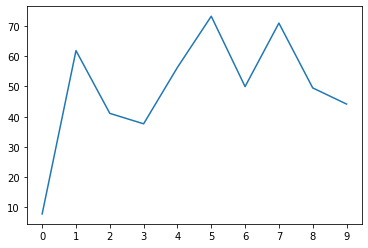

In [26]:
plt.plot(list(range(len(loss_list))), loss_list)
plt.xticks(list(range(len(loss_list))))
plt.show()

## Validation

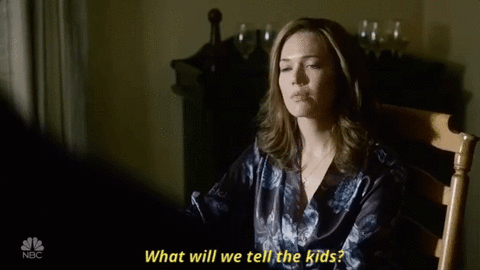

[['all', 'families', 'go', 'through', 'some', 'trauma', 'and', 'dysfunction']] ['person', 'is', 'obsessed', 'there', 'leave', 'a', 'person', 'is', 'obsessed', 'there', 'leave', 'a', 'person', 'is', 'obsessed', 'there', 'leave', 'a', 'person'] 0


/userhome/cs/u3595931/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/userhome/cs/u3595931/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/userhome/cs/u3595931/anaconda3/lib/python3.8/site-packages/nltk/translate/bleu_score.py:516: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using low

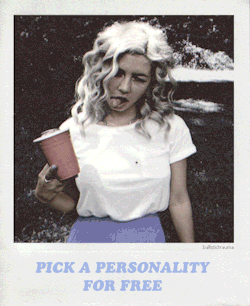

[['the', 'valley', 'of', 'the', 'dolls']] ['people', 'must', 'try', 'the', 'people', 'must', 'try', 'at', 'the', 'people', 'must', 'try', 'at', 'the', 'people', 'must', 'try', 'at', 'the'] 1.0377133938315695e-231


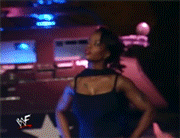

[['person', 'these', 'matches', 'were', 'hard', 'to', 'find', 'a', 'lot', 'of', 'the', 'stuff', 'is', 'rare', 'and', 'if', 'found', 'has', 'terrible']] ['people', 'is', 'why', 'a', 'opponent', 'throwing', 'person', 'is', 'why', 'a', 'opponent', 'throwing', 'a', 'opponent', 'throwing', 'a', 'opponent', 'throwing', 'a'] 2.186132044615858e-231


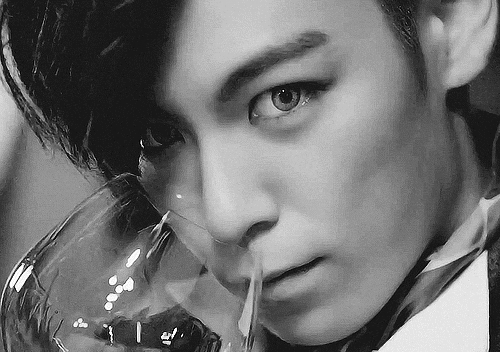

[['a', 'person', 'never', 'thought', 'a', 'person', 'would', 'ever', 'say', 'a', 'person', 'is', 'super', 'jealous', 'of', 'a', 'glass']] ['person', 'makes', 'up', 'while', 'eating', 'breakfast', '<EOS>'] 2.4545509649264123e-231


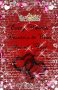

[['every', 'woman', 'deserves', 'to', 'wear']] ['coating', 'person', 'wears', 'a', 'sunset', 'by', 'a', 'sunset', 'by', 'a', 'sunset', 'by', 'a', 'sunset', 'by', 'a', 'sunset', 'by', 'a'] 2.4545509649264123e-231


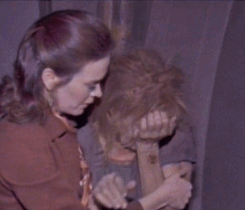

[['friends', 'trying', 'to', 'get', 'you', 'home', 'from', 'a', 'party']] ['people', 'is', 'width', 'of', 'paper', 'with', 'snowboarding', '<EOS>'] 2.4545509649264123e-231


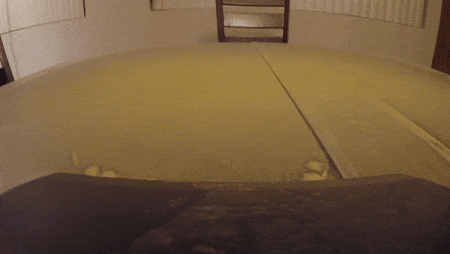

[['hash', 'being', 'collected', 'in', 'a', 'view']] ['person', 'is', 'off', 'how', 'to', 'have', 'some', 'characters', 'is', 'off', 'how', 'to', 'have', 'some', 'characters', 'is', 'off', 'how', 'to'] 2.4545509649264123e-231


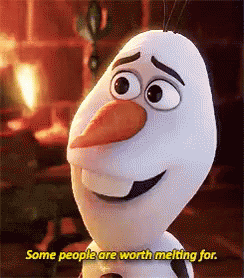

[['some', 'people', 'are', 'worth', 'melting', 'for', 'love']] ['hair', 'while', 'hair', 'while', 'hair', 'while', 'hair', 'while', 'hair', 'while', 'hair', 'while', 'hair', 'while', 'hair', 'while', 'hair', 'while', 'hair'] 2.4545509649264123e-231


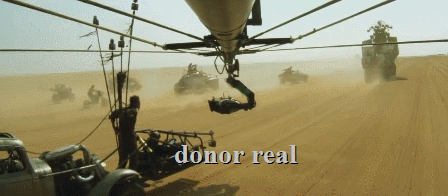

[['may', 'time', 'measured', 'through', 'a', 'keyboard']] ['the', 'person', 'is', 'reversed', 'on', 'the', 'light', 'between', 'us', 'the', 'in', 'the', 'in', 'the', 'in', 'the', 'in', 'the', 'in'] 2.4545509649264123e-231


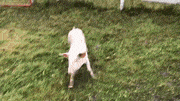

[['people', 'run', 'on', 'grass', 'for', 'the', 'time', 'at', 'sanctuary']] ['this', 'vacuum', '<EOS>'] 2.4545509649264123e-231
BLEU score: 1.8731448219838772e-156


In [27]:
bleu = 0
for val_num in range(VAL_SAMPLE_NUM):
    true_reference = [reference.split() for reference in val_id_to_captions[val_ids[val_num]]]
    predicted_reference = caption_image(validation_vectors[val_num]).split()
    bleu += sentence_bleu(true_reference, predicted_reference)
    if (val_num<10):
        display.display(display.Image(f"{val_id_to_file[val_ids[val_num]]}0.png"))
        print(true_reference, predicted_reference, bleu)
bleu /= VAL_SAMPLE_NUM
print(f'BLEU score: {bleu}')

## Testing

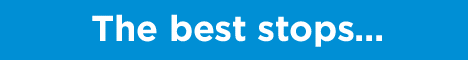

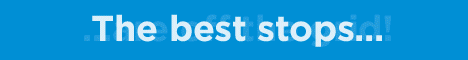

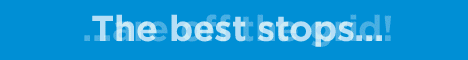

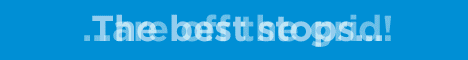

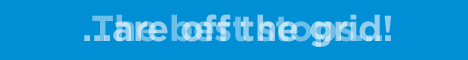

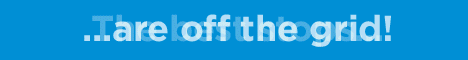

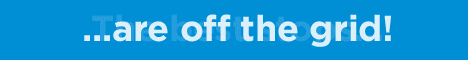

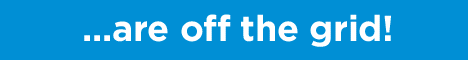

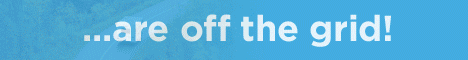

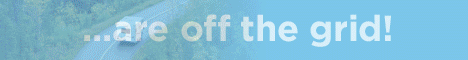

person is definitely <EOS>


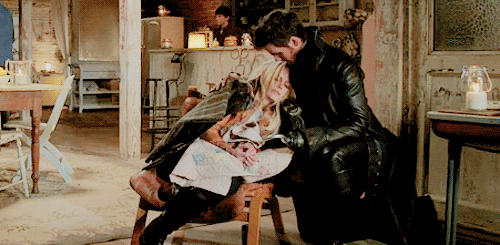

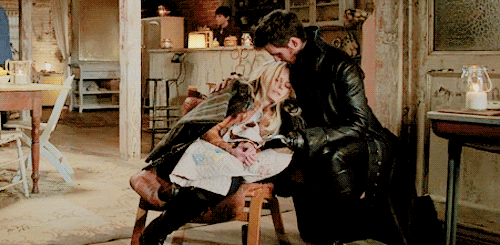

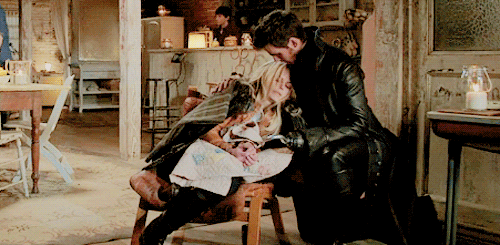

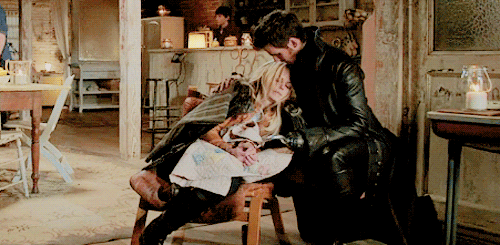

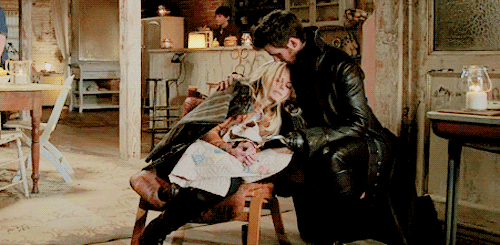

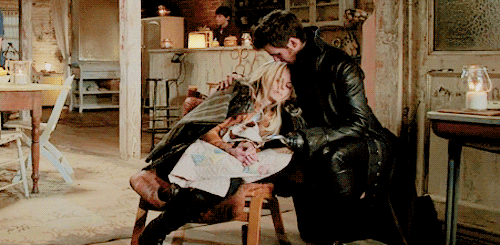

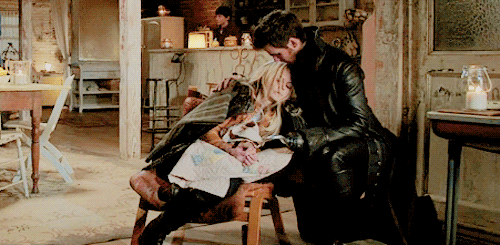

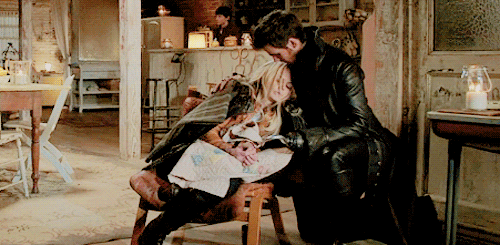

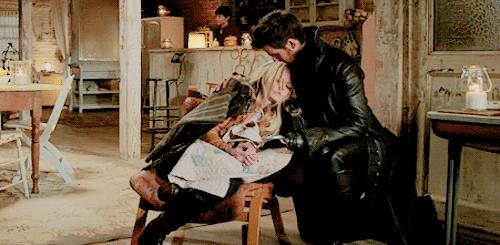

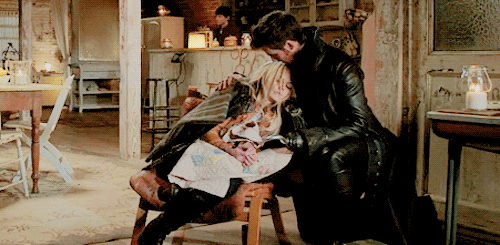

people person and men asking and people in love and men asking and people in love and men asking


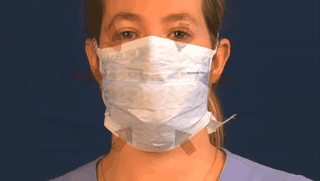

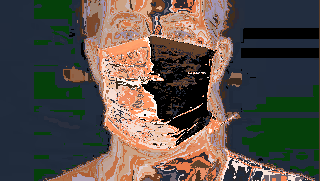

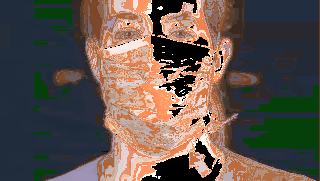

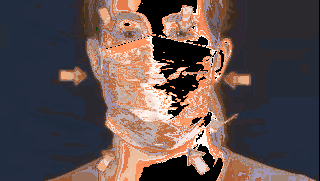

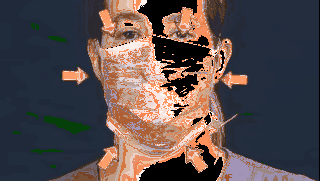

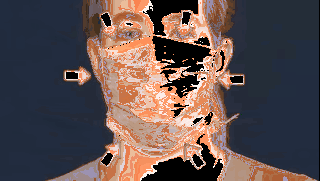

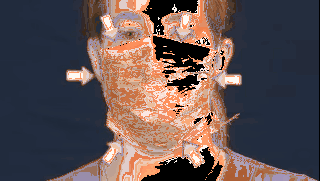

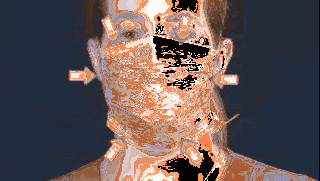

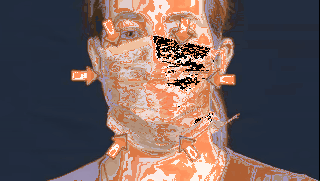

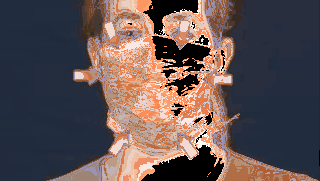

person is dancing with love with love with love with love with love with love with love with love


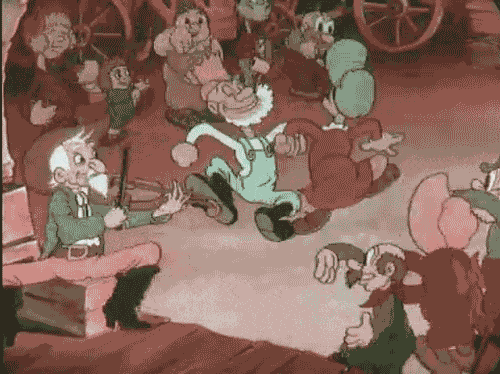

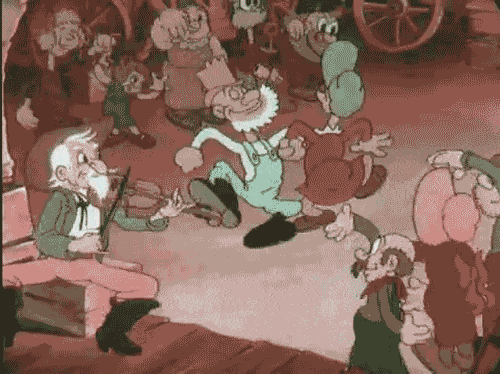

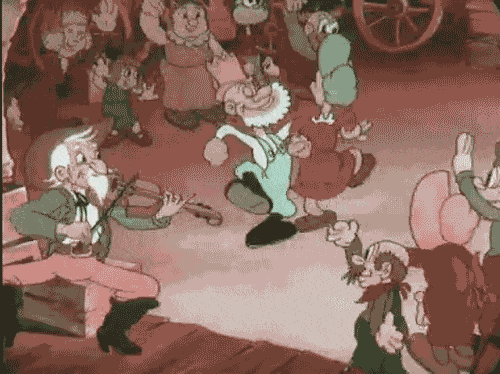

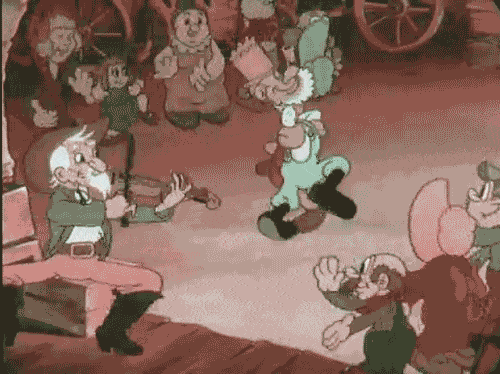

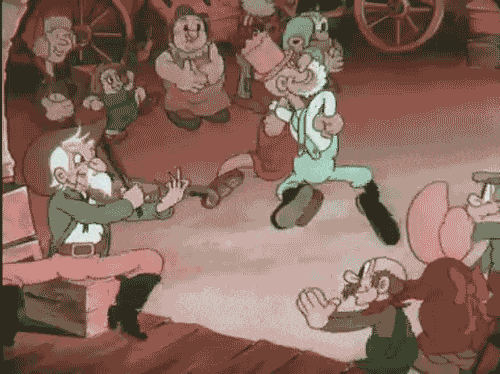

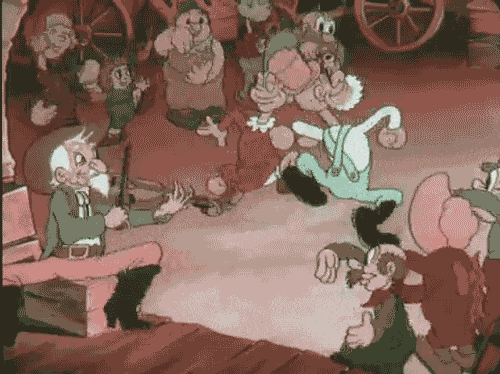

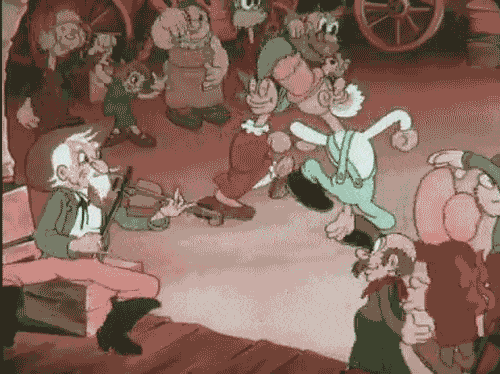

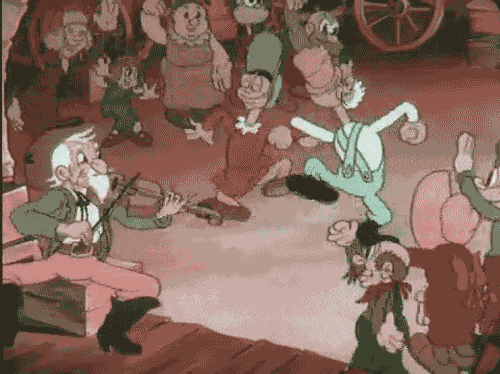

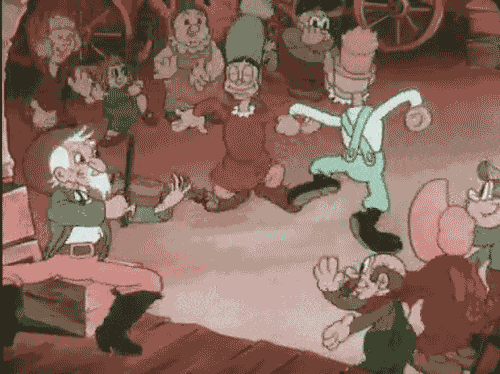

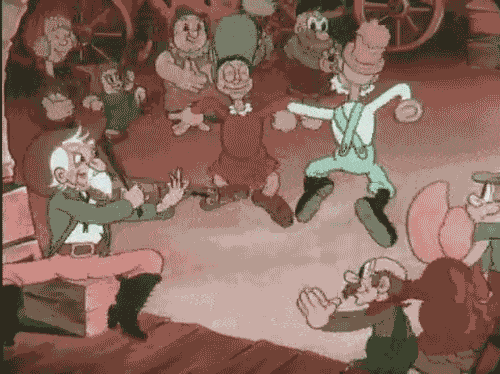

person is in love this is really that roll towards and roll towards and roll towards and roll towards


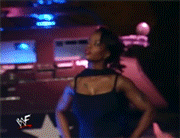

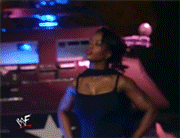

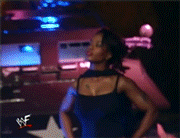

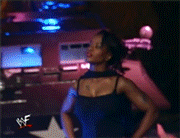

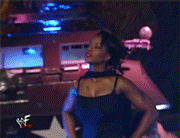

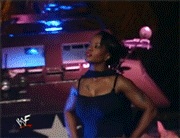

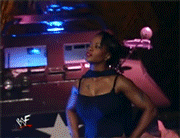

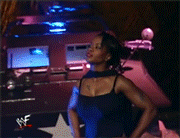

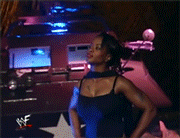

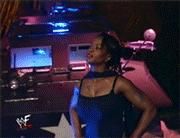

people is why a opponent throwing person is why a opponent throwing a opponent throwing a opponent throwing a


In [28]:
test_vid_ids = random.sample(range(VAL_SAMPLE_NUM), k=5)
for test_vid_id in test_vid_ids:
    for i in range(N_FRAMES):
        display.display(display.Image(f"{val_id_to_file[val_ids[test_vid_id]]}{i}.png"))
    print(caption_image(validation_vectors[test_vid_id]))


# Reference
http://shikib.com/captioning.html

https://towardsdatascience.com/how-to-build-an-encoder-decoder-translation-model-using-lstm-with-python-and-keras-a31e9d864b9b